In [693]:
import numbers
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import tree
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_blobs
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree

## Carregamento e tratamento da base

In [694]:
pathsAndLinksTemp = pd.read_excel ('PathsAndLinksExcel.xlsx')

pathsAndLinksTemp.to_csv("PathsAndLinks.csv", index = None, header = True)

pathsAndLinksDf = pd.DataFrame(pd.read_csv("PathsAndLinks.csv"))

pathsAndLinksDf.head()

,OrigZoneNo,DestZoneNo,Index,Path_Volume,Path_UnloadedTime,Path_UnloadedSpeed,Path_LoadedTime,Path_LoadedSpeed,Links_Count,Links_MinCarCapacity,...,Links_MinUnloadedTime,Links_MaxUnloadedTime,Links_AvgUnloadedTime,Links_SumUnloadedTime,Links_MinLoadedTime,Links_MaxLoadedTime,Links_AvgLoadedTime,Links_SumLoadedTime,Links_ToNodeNo,Links_FromNodeNo
0,10,20,1,19208.000,2min 23s,36km/h,3min 10s,27km/h,3,500,...,8s,20s,13s,40s,8s,22s,14s,43s,"2642,153,3111","3412,2642,153"
1,10,20,2,1064.000,2min 14s,38km/h,3min 10s,27km/h,3,500,...,7s,39s,22s,1min 6s,7s,43s,24s,1min 12s,"2645,153,3111","3064,2645,153"
2,10,30,1,36624.000,2min,38km/h,2min 22s,32km/h,3,500,...,11s,30s,21s,1min 2s,13s,35s,23s,1min 10s,"138,3351,162","137,138,3351"
3,10,40,1,18483.000,3min 5s,29km/h,3min 32s,26km/h,7,500,...,6s,22s,14s,1min 41s,6s,24s,15s,1min 45s,"10000658,3081,2649,130,139,140,3389","3064,10000658,3081,2649,130,139,140"
4,10,40,2,0.481,2min 59s,32km/h,3min 32s,27km/h,5,500,...,6s,45s,23s,1min 56s,6s,47s,27s,2min 14s,"3404,130,139,140,3389","3077,3404,130,139,140"


In [695]:
for x in pathsAndLinksDf:
    if pathsAndLinksDf[x].dtypes == object:
        pathsAndLinksDf[x] = pathsAndLinksDf[x].apply(lambda x: x.replace('km/h', ''))
        pathsAndLinksDf[x] = pathsAndLinksDf[x].apply(lambda x: x.replace('km', ''))
        pathsAndLinksDf[x] = pathsAndLinksDf[x].apply(lambda x: x.replace('min', '.'))
        pathsAndLinksDf[x] = pathsAndLinksDf[x].apply(lambda x: x.replace(' ', ''))
        pathsAndLinksDf[x] = pathsAndLinksDf[x].apply(lambda x: x.replace('h', ''))
        pathsAndLinksDf[x] = pathsAndLinksDf[x].apply(lambda x: x.replace('s', ''))


singleLinks = pathsAndLinksDf[['Links_ToNodeNo', 'Links_FromNodeNo']]

pathsAndLinksDf = pathsAndLinksDf.drop(['DestZoneNo','Links_ToNodeNo', 'Links_FromNodeNo', 'OrigZoneNo', 'Index', 'Path_Volume'], axis=1)

pathsAndLinksDf = pathsAndLinksDf.apply(pd.to_numeric)

Legenda:

DestZoneNo -> Numero da zona de destino [int64]

(Removida) Path_Volume -> Cálculo de volume de veículos considerando o path (caminho inteiro) [float64]

Path_UnloadedTime -> Tempo de locomoção no path considerando as vias sem transito (calculo mais simplificado considerando a velocidade média da via e a distância) [float64]

Path_UnloadedSpeed ->  Velocidade de locomoção no path considerando as vias sem transito [int64]

Path_LoadedTime -> Tempo de locomoção no path considerando as vias com transito (vem ao rodar a simulação) [float64]

Path_LoadedSpeed -> Velocidade de locomoção no path considerando as vias com transito [int64]

Links_Count -> Quantidade de links que compõe o path [int64]

Links_(Min, Max, Avg, Sum)CarCapacity -> Colunas referente à capacidade de carros nos links/vias [int64]

Links_(Min, Max, Avg, Sum)Length -> Colunas referente ao tamanho das vias [float64]

Links_(Min, Max, Avg, Sum)OfCars -> Colunas referente à quantidade de carros nos links/vias [int64]

Links_(Min, Max, Avg)LoadedSpeed -> Colunas referente à velocidade nas vias/links considerando o transito [int64]

Links_(Min, Max, Avg, Sum)UnloadedTime -> Colunas referente ao tempo de locomoção nas vias/links não considerando o transito [int64, float64]

Links_(Min, Max, Avg, Sum)LoadedTime -> Colunas referente ao tempo de locomoção nas vias/links considerando o transito [int64, float64]

Colunas excluídas:
OrigZoneNo -> Número de origem (sempre 10)  [int64]

Index -> Repetitivo e considera os pares de origem destino, não vi utilidade (a confirmar) [int64]

Links_FromNodeNo -> Lista de nós de partida (essa coluna e a abaixo podem ter alguma utilidade, mas não enxerguei ainda) [object]

Links_ToNodeNo -> Lista de nós de Chegada [object]


In [696]:
pathsAndLinksDf

,Path_UnloadedTime,Path_UnloadedSpeed,Path_LoadedTime,Path_LoadedSpeed,Links_Count,Links_MinCarCapacity,Links_MaxCarCapacity,Links_AvgCarCapacity,Links_SumCarCapacity,Links_MinLength,...,Links_MaxLoadedSpeed,Links_AvgLoadedSpeed,Links_MinUnloadedTime,Links_MaxUnloadedTime,Links_AvgUnloadedTime,Links_SumUnloadedTime,Links_MinLoadedTime,Links_MaxLoadedTime,Links_AvgLoadedTime,Links_SumLoadedTime
0,2.23,36,3.10,27,3,500,800,600,1800,0.066,...,29,28,8,20.00,13,40.00,8,22.00,14,43.00
1,2.14,38,3.10,27,3,500,800,600,1800,0.055,...,29,28,7,39.00,22,1.60,7,43.00,24,1.12
2,2.00,38,2.22,32,3,500,800,600,1800,0.090,...,29,26,11,30.00,21,1.20,13,35.00,23,1.10
3,3.50,29,3.32,26,7,500,2000,971,6800,0.051,...,30,29,6,22.00,14,1.41,6,24.00,15,1.45
4,2.59,32,3.32,27,5,500,2000,860,4300,0.051,...,29,27,6,45.00,23,1.56,6,47.00,27,2.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,11.40,51,15.18,39,34,500,4200,2288,77800,0.016,...,80,41,1,1.18,17,9.29,2,1.19,22,12.34
135,5.28,34,9.54,19,17,500,4200,1918,32600,0.007,...,38,26,0,1.19,14,4.30,1,1.19,22,6.11
136,6.40,34,9.53,21,20,500,4200,1555,31100,0.007,...,38,24,0,1.19,13,4.21,1,1.19,21,6.54
137,5.45,45,10.33,25,22,500,4200,2609,57400,0.019,...,75,37,1,38.00,12,4.24,2,51.00,19,6.54


<AxesSubplot:>

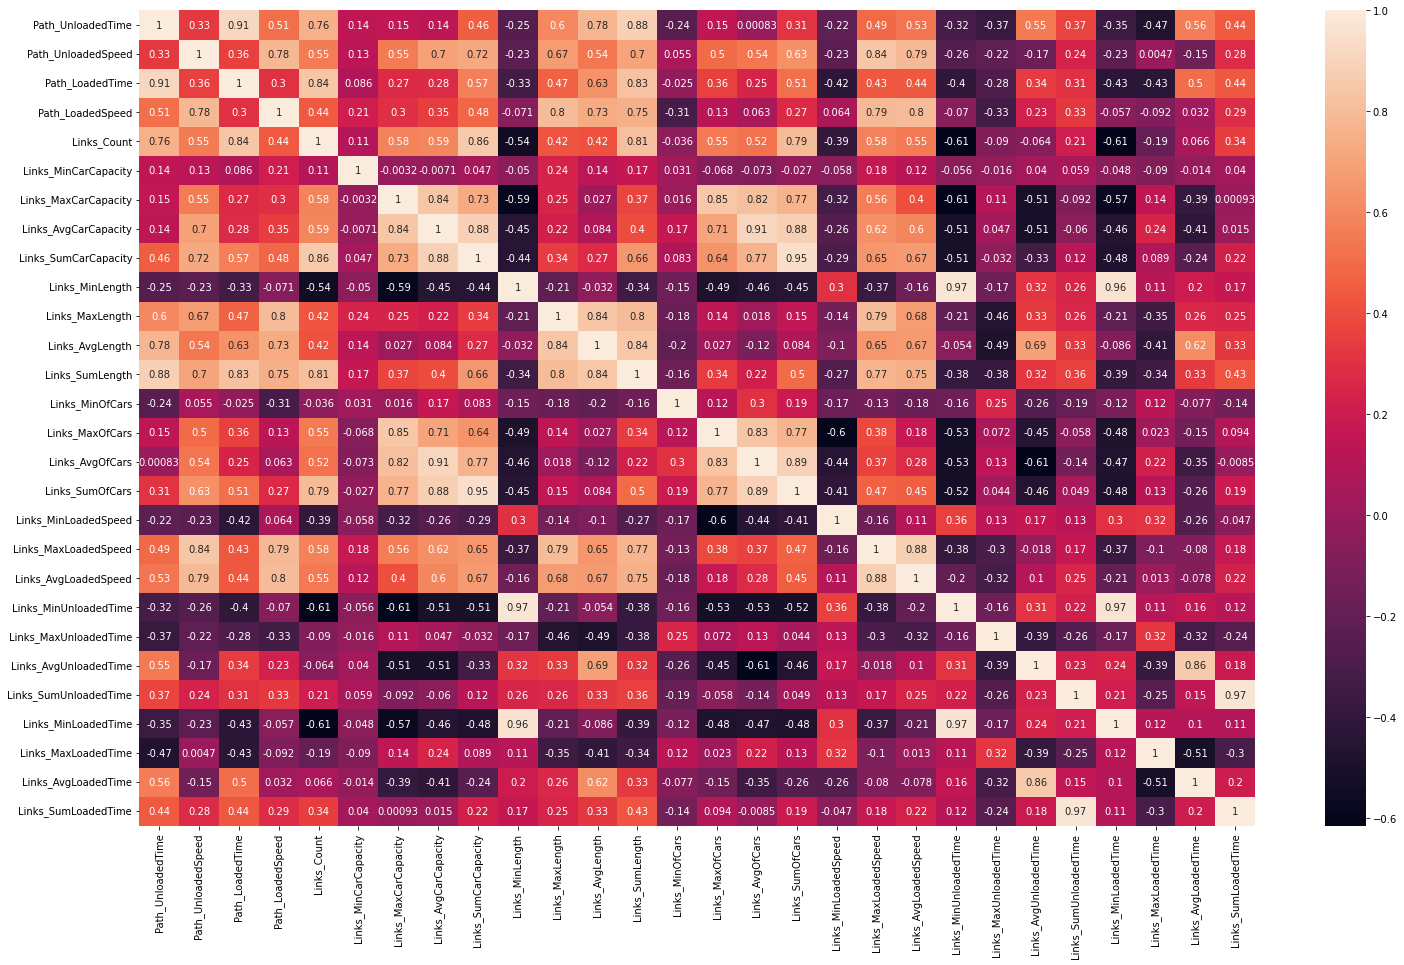

In [697]:
fig_dims = (25,15)
fig, ax = plt.subplots(figsize=fig_dims)

corr = pathsAndLinksDf.corr()
sns.heatmap(corr, annot=True)

In [698]:
def print_results(predictions, y_testy):
    errors = abs(predictions - y_testy)
    out_mape = round(np.mean(errors), 2)
    print('    Mean Absolute Error:', out_mape, 'degrees.')
    mape = 100 * (errors / y_testy)
    accuracy = 100 - np.mean(mape)
    accuracy = round(accuracy, 2)
    print('    Accuracy:', accuracy, '%.')
    return accuracy, out_mape


In [699]:
def save_accuracy(predictions, y_testy):
    errors = abs(predictions - y_testy)
    mape = 100 * (errors / y_testy)
    accuracy = 100 - np.mean(mape)
    accuracy = round(accuracy, 2)
    return accuracy


# Dados simulados completos

## Y = Links_SumOfCars

In [700]:
df_SumOfCars = pathsAndLinksDf.copy()

In [701]:
y = np.array(df_SumOfCars['Links_SumOfCars'])
X = df_SumOfCars.drop(['Links_SumOfCars', 'Path_LoadedSpeed', 'Path_LoadedTime'], axis = 1)
x_names = list(X.columns)
X = np.array(X)

In [702]:
tscv = TimeSeriesSplit(n_splits=2)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

### Decision Tree Regressor Pipeline (Links_SumOfCars)

In [703]:
DT_regressor = DecisionTreeRegressor(random_state=42)
DT_regressor.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [704]:
search_paramns = [
    dict(dec_tree__criterion=["squared_error", "friedman_mse", "absolute_error", "poisson"],
         dec_tree__max_depth=list(range(5,30,2)),
            dec_tree__max_features=["auto","sqrt", "log2"])
]

pipe = Pipeline([
    ('dec_tree', DT_regressor)
])

search = GridSearchCV(estimator=pipe,
                     param_grid=search_paramns,
                     cv=tscv,
                     return_train_score=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [705]:
%%time
search.fit(X_train, y_train)

CPU times: total: 375 ms
Wall time: 386 ms


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=None),
             estimator=Pipeline(steps=[('dec_tree',
                                        DecisionTreeRegressor(random_state=42))]),
             param_grid=[{'dec_tree__criterion': ['squared_error',
                                                  'friedman_mse',
                                                  'absolute_error', 'poisson'],
                          'dec_tree__max_depth': [5, 7, 9, 11, 13, 15, 17, 19,
                                                  21, 23, 25, 27, 29],
                          'dec_tree__max_features': ['auto', 'sqrt', 'log2']}],
             return_train_score=True)

In [706]:
search.best_params_

{'dec_tree__criterion': 'absolute_error',
 'dec_tree__max_depth': 9,
 'dec_tree__max_features': 'sqrt'}

In [707]:
search.best_estimator_

Pipeline(steps=[('dec_tree',
                 DecisionTreeRegressor(criterion='absolute_error', max_depth=9,
                                       max_features='sqrt', random_state=42))])

In [708]:
y_pred = search.predict(X_test)

r2_score = DT_regressor.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)
print(f'r2: {r2_score}    MSE: {mse}')

r2: 0.4518121670276012    MSE: 63788970.28571428


In [709]:
print_results(y_pred, y_test)

    Mean Absolute Error: 6174.19 degrees.
    Accuracy: 83.82 %.


(83.82, 6174.19)

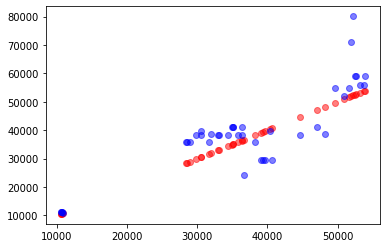

In [710]:
plt.scatter(y_test, y_test, c='red', alpha=0.5)
plt.scatter(y_test, y_pred, c='blue', alpha=0.5)

### Random Forest Pipeline (Links_SumOfCars)

In [711]:
forrest_model_reg = RandomForestRegressor(random_state=37)
forrest_model_reg.fit(X_train, y_train)

RandomForestRegressor(random_state=37)

In [712]:
search_paramns = [{
    'forest__criterion': ["squared_error", "absolute_error"],
    'forest__n_estimators': list(range(400,420, 2)), 
    'forest__max_features': ["sqrt", "log2"]
}]

pipe = Pipeline([
    ('forest', forrest_model_reg)
])

search = GridSearchCV(estimator=pipe,
                     param_grid=search_paramns,
                     cv=5,
                     return_train_score=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [713]:
%%time
search.fit(X_train, y_train)

CPU times: total: 60 s
Wall time: 1min


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('forest',
                                        RandomForestRegressor(random_state=37))]),
             param_grid=[{'forest__criterion': ['squared_error',
                                                'absolute_error'],
                          'forest__max_features': ['sqrt', 'log2'],
                          'forest__n_estimators': [400, 402, 404, 406, 408, 410,
                                                   412, 414, 416, 418]}],
             return_train_score=True)

In [714]:
search.best_params_

{'forest__criterion': 'absolute_error',
 'forest__max_features': 'log2',
 'forest__n_estimators': 400}

In [715]:
search.best_estimator_

Pipeline(steps=[('forest',
                 RandomForestRegressor(criterion='absolute_error',
                                       max_features='log2', n_estimators=400,
                                       random_state=37))])

In [716]:
y_pred = search.predict(X_test)

r2_score = forrest_model_reg.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)
print(f'r2: {r2_score}    MSE: {mse}')

r2: 0.7962967753767871    MSE: 13101531.439988093


In [717]:
print_results(y_pred, y_test)

    Mean Absolute Error: 2516.37 degrees.
    Accuracy: 93.42 %.


(93.42, 2516.37)

In [718]:
forrest_model_reg = RandomForestRegressor(n_estimators = 411,criterion='absolute_error',max_features= 'sqrt', random_state=37)
forrest_model_reg.fit(X_train, y_train)

forrest_predictions = forrest_model_reg.predict(X_test)
print_results(forrest_predictions, y_test)

    Mean Absolute Error: 2496.95 degrees.
    Accuracy: 93.6 %.


(93.6, 2496.95)

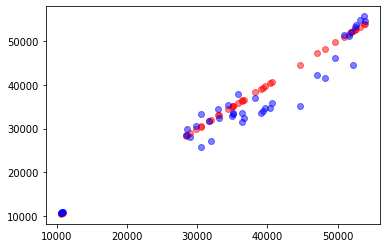

In [719]:
plt.scatter(y_test, y_test, c='red', alpha=0.5)
plt.scatter(y_test, forrest_predictions, c='blue', alpha=0.5)

In [720]:
rf_SumOfCars = save_accuracy(forrest_predictions, y_test)

## Y = Path_LoadedSpeed

In [721]:
df_LoadedSpeed = pathsAndLinksDf.copy()

In [722]:
y = np.array(df_LoadedSpeed['Path_LoadedSpeed'])
X = df_LoadedSpeed.drop(['Links_SumOfCars', 'Path_LoadedSpeed', 'Path_LoadedTime'], axis = 1)
x_names = list(X.columns)
X = np.array(X)

In [723]:
tscv = TimeSeriesSplit(n_splits=2)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

### Decision Tree Regressor Pipeline (Path_LoadedSpeed)

In [724]:
DT_regressor = DecisionTreeRegressor(random_state=42)
DT_regressor.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [725]:
search_paramns = [
    dict(dec_tree__criterion=["squared_error", "friedman_mse", "absolute_error", "poisson"],
         dec_tree__max_depth=list(range(10,600,50)),
            dec_tree__max_features=["auto","sqrt", "log2"])
]

pipe = Pipeline([
    ('dec_tree', DT_regressor)
])

search = GridSearchCV(estimator=pipe,
                     param_grid=search_paramns,
                     cv=tscv,
                     return_train_score=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [726]:
%%time
search.fit(X_train, y_train)

CPU times: total: 375 ms
Wall time: 369 ms


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=None),
             estimator=Pipeline(steps=[('dec_tree',
                                        DecisionTreeRegressor(random_state=42))]),
             param_grid=[{'dec_tree__criterion': ['squared_error',
                                                  'friedman_mse',
                                                  'absolute_error', 'poisson'],
                          'dec_tree__max_depth': [10, 60, 110, 160, 210, 260,
                                                  310, 360, 410, 460, 510,
                                                  560],
                          'dec_tree__max_features': ['auto', 'sqrt', 'log2']}],
             return_train_score=True)

In [727]:
search.best_params_

{'dec_tree__criterion': 'absolute_error',
 'dec_tree__max_depth': 10,
 'dec_tree__max_features': 'log2'}

In [728]:
search.best_estimator_

Pipeline(steps=[('dec_tree',
                 DecisionTreeRegressor(criterion='absolute_error', max_depth=10,
                                       max_features='log2', random_state=42))])

In [729]:
y_pred = search.predict(X_test)

r2_score = DT_regressor.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)
print(f'r2: {r2_score}    MSE: {mse}')

r2: -0.4131386861313868    MSE: 73.30952380952381


In [730]:
print_results(y_pred, y_test)

    Mean Absolute Error: 5.07 degrees.
    Accuracy: 81.29 %.


(81.29, 5.07)

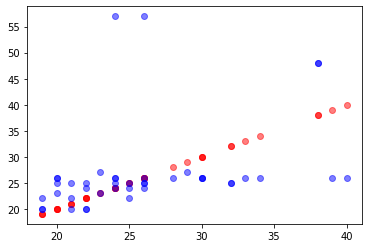

In [731]:
plt.scatter(y_test, y_test, c='red', alpha=0.5)
plt.scatter(y_test, y_pred, c='blue', alpha=0.5)

### Random Forest Pipeline (Path_LoadedTime)

In [732]:
forrest_model_reg = RandomForestRegressor(random_state=37)
forrest_model_reg.fit(X_train, y_train)

RandomForestRegressor(random_state=37)

In [733]:
search_paramns = [{
    'forest__criterion': ["squared_error", "absolute_error"],
    'forest__n_estimators': list(range(180,200, 1)), 
    'forest__max_features': ["sqrt", "log2"]
}]

pipe = Pipeline([
    ('forest', forrest_model_reg)
])

search = GridSearchCV(estimator=pipe,
                     param_grid=search_paramns,
                     cv=5,
                     return_train_score=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [734]:
%%time
search.fit(X_train, y_train)

CPU times: total: 59.1 s
Wall time: 59.4 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('forest',
                                        RandomForestRegressor(random_state=37))]),
             param_grid=[{'forest__criterion': ['squared_error',
                                                'absolute_error'],
                          'forest__max_features': ['sqrt', 'log2'],
                          'forest__n_estimators': [180, 181, 182, 183, 184, 185,
                                                   186, 187, 188, 189, 190, 191,
                                                   192, 193, 194, 195, 196, 197,
                                                   198, 199]}],
             return_train_score=True)

In [735]:
search.best_params_

{'forest__criterion': 'squared_error',
 'forest__max_features': 'sqrt',
 'forest__n_estimators': 185}

In [736]:
search.best_estimator_

Pipeline(steps=[('forest',
                 RandomForestRegressor(max_features='sqrt', n_estimators=185,
                                       random_state=37))])

In [737]:
y_pred = search.predict(X_test)

r2_score = forrest_model_reg.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)
print(f'r2: {r2_score}    MSE: {mse}')

r2: 0.622155401459854    MSE: 14.003650213920485


In [738]:
print_results(y_pred, y_test)

    Mean Absolute Error: 2.77 degrees.
    Accuracy: 89.91 %.


(89.91, 2.77)

In [739]:
forrest_model_reg = RandomForestRegressor(n_estimators = 185,criterion='squared_error',max_features= 'sqrt', random_state=37)
forrest_model_reg.fit(X_train, y_train)

forrest_predictions = forrest_model_reg.predict(X_test)
print_results(forrest_predictions, y_test)

    Mean Absolute Error: 2.78 degrees.
    Accuracy: 89.89 %.


(89.89, 2.78)

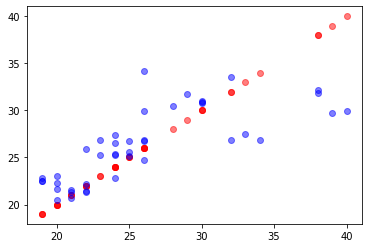

In [740]:
plt.scatter(y_test, y_test, c='red', alpha=0.5)
plt.scatter(y_test, forrest_predictions, c='blue', alpha=0.5)

In [741]:
rf_LoadedSpeed = save_accuracy(forrest_predictions, y_test)

## Y = Path_LoadedTime

In [742]:
df_LoadedTime = pathsAndLinksDf.copy()

In [743]:
y = np.array(df_LoadedTime['Path_LoadedTime'])
X = df_LoadedTime.drop(['Links_SumOfCars', 'Path_LoadedSpeed', 'Path_LoadedTime'], axis = 1)
x_names = list(X.columns)
X = np.array(X)

In [744]:
tscv = TimeSeriesSplit(n_splits=2)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

### Decision Tree Regressor Pipeline (Path_LoadedTime)

In [745]:
DT_regressor = DecisionTreeRegressor(random_state=42)
DT_regressor.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [746]:
search_paramns = [
    dict(dec_tree__criterion=["squared_error", "friedman_mse", "absolute_error", "poisson"],
         dec_tree__max_depth=list(range(10,600,50)),
            dec_tree__max_features=["auto","sqrt", "log2"])
]

pipe = Pipeline([
    ('dec_tree', DT_regressor)
])

search = GridSearchCV(estimator=pipe,
                     param_grid=search_paramns,
                     cv=tscv,
                     return_train_score=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [747]:
%%time
search.fit(X_train, y_train)

CPU times: total: 609 ms
Wall time: 613 ms


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=None),
             estimator=Pipeline(steps=[('dec_tree',
                                        DecisionTreeRegressor(random_state=42))]),
             param_grid=[{'dec_tree__criterion': ['squared_error',
                                                  'friedman_mse',
                                                  'absolute_error', 'poisson'],
                          'dec_tree__max_depth': [10, 60, 110, 160, 210, 260,
                                                  310, 360, 410, 460, 510,
                                                  560],
                          'dec_tree__max_features': ['auto', 'sqrt', 'log2']}],
             return_train_score=True)

In [748]:
search.best_params_

{'dec_tree__criterion': 'poisson',
 'dec_tree__max_depth': 60,
 'dec_tree__max_features': 'auto'}

In [749]:
search.best_estimator_

Pipeline(steps=[('dec_tree',
                 DecisionTreeRegressor(criterion='poisson', max_depth=60,
                                       max_features='auto', random_state=42))])

In [750]:
y_pred = search.predict(X_test)

r2_score = DT_regressor.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)
print(f'r2: {r2_score}    MSE: {mse}')

r2: 0.23204369956522253    MSE: 16.420145238095238


In [751]:
print_results(y_pred, y_test)

    Mean Absolute Error: 2.88 degrees.
    Accuracy: 82.35 %.


(82.35, 2.88)

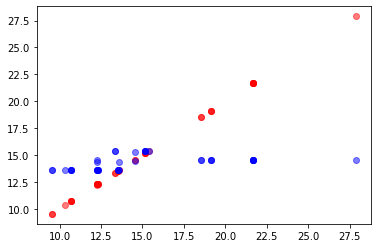

In [752]:
plt.scatter(y_test, y_test, c='red', alpha=0.5)
plt.scatter(y_test, y_pred, c='blue', alpha=0.5)

### Random Forest Pipeline (Path_LoadedTime)

In [753]:
forrest_model_reg = RandomForestRegressor(random_state=37)
forrest_model_reg.fit(X_train, y_train)

RandomForestRegressor(random_state=37)

In [754]:
search_paramns = [{
    'forest__criterion': ["squared_error", "absolute_error"],
    'forest__n_estimators': list(range(90,130, 1)), 
    'forest__max_features': ["sqrt", "log2"]
}]

pipe = Pipeline([
    ('forest', forrest_model_reg)
])

search = GridSearchCV(estimator=pipe,
                     param_grid=search_paramns,
                     cv=5,
                     return_train_score=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [755]:
%%time
search.fit(X_train, y_train)

CPU times: total: 1min 5s
Wall time: 1min 5s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('forest',
                                        RandomForestRegressor(random_state=37))]),
             param_grid=[{'forest__criterion': ['squared_error',
                                                'absolute_error'],
                          'forest__max_features': ['sqrt', 'log2'],
                          'forest__n_estimators': [90, 91, 92, 93, 94, 95, 96,
                                                   97, 98, 99, 100, 101, 102,
                                                   103, 104, 105, 106, 107, 108,
                                                   109, 110, 111, 112, 113, 114,
                                                   115, 116, 117, 118, 119, ...]}],
             return_train_score=True)

In [756]:
search.best_params_

{'forest__criterion': 'squared_error',
 'forest__max_features': 'sqrt',
 'forest__n_estimators': 126}

In [757]:
search.best_estimator_

Pipeline(steps=[('forest',
                 RandomForestRegressor(max_features='sqrt', n_estimators=126,
                                       random_state=37))])

In [758]:
y_pred = search.predict(X_test)

r2_score = forrest_model_reg.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)
print(f'r2: {r2_score}    MSE: {mse}')

r2: 0.4873383586109321    MSE: 10.475538417827424


In [759]:
print_results(y_pred, y_test)

    Mean Absolute Error: 2.19 degrees.
    Accuracy: 87.8 %.


(87.8, 2.19)

In [760]:
forrest_model_reg = RandomForestRegressor(n_estimators = 109,criterion='squared_error',max_features= 'sqrt', random_state=37)
forrest_model_reg.fit(X_train, y_train)

forrest_predictions = forrest_model_reg.predict(X_test)
print_results(forrest_predictions, y_test)

    Mean Absolute Error: 2.18 degrees.
    Accuracy: 87.86 %.


(87.86, 2.18)

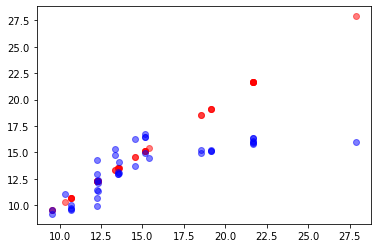

In [761]:
plt.scatter(y_test, y_test, c='red', alpha=0.5)
plt.scatter(y_test, forrest_predictions, c='blue', alpha=0.5)

In [762]:
rf_LoadedTime = save_accuracy(forrest_predictions, y_test)

# Esparsidade de dados

## Dataframe com dados esparsos

In [763]:
df_sparse = pathsAndLinksDf.copy()

In [764]:
def generate_new_sparse(original_df, perc):
        df_sparse = original_df.copy()

        for column in original_df.copy():
                # Sample de perc% dos itens
                items_to_change = df_sparse.sample(frac=perc)

                # O que sobrou sem o sample
                items_left = df_sparse.drop(items_to_change.index)

                # Operacao de esparsamento
                mean = original_df[column].mean()
                items_to_change[column] = items_to_change[column].apply(lambda x: mean)

                # Insere de volta no dataframe
                df_sparse = pd.concat([items_left, items_to_change])
                df_sparse.sort_index(inplace=True)

        return df_sparse


In [765]:
df_sparse_base = generate_new_sparse(pathsAndLinksDf, 0.30)

### Y = Links_SumOfCars (dados esparsados aleatoriamente)

In [766]:
y = np.array(df_sparse_base['Links_SumOfCars'])
X = df_sparse_base.drop(['Links_SumOfCars', 'Path_LoadedSpeed', 'Path_LoadedTime'], axis = 1)
X = np.array(X)

In [767]:
tscv = TimeSeriesSplit(n_splits=2)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [768]:
forrest_model_reg = RandomForestRegressor(random_state=37)
forrest_model_reg.fit(X_train, y_train)

RandomForestRegressor(random_state=37)

In [769]:
search_paramns = [{
    'forest__criterion': ["squared_error", "absolute_error"],
    'forest__n_estimators': list(range(65,71, 1)), 
    'forest__max_features': ["sqrt", "log2"]
}]

pipe = Pipeline([
    ('forest', forrest_model_reg)
])

search = GridSearchCV(estimator=pipe,
                     param_grid=search_paramns,
                     cv=5,
                     return_train_score=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)


In [770]:
%%time
search.fit(X_train, y_train)

CPU times: total: 7.42 s
Wall time: 7.45 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('forest',
                                        RandomForestRegressor(random_state=37))]),
             param_grid=[{'forest__criterion': ['squared_error',
                                                'absolute_error'],
                          'forest__max_features': ['sqrt', 'log2'],
                          'forest__n_estimators': [10, 20, 30, 40, 50, 60, 70,
                                                   80, 90]}],
             return_train_score=True)

In [771]:
search.best_params_

{'forest__criterion': 'absolute_error',
 'forest__max_features': 'log2',
 'forest__n_estimators': 70}

In [772]:
search.best_estimator_

Pipeline(steps=[('forest',
                 RandomForestRegressor(criterion='absolute_error',
                                       max_features='log2', n_estimators=70,
                                       random_state=37))])

In [773]:
y_pred = search.predict(X_test)

r2_score = forrest_model_reg.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)
print(f'r2: {r2_score}    MSE: {mse}')

r2: 0.08067855421649117    MSE: 120399900.32021497


In [774]:
print_results(y_pred, y_test)

    Mean Absolute Error: 9256.16 degrees.
    Accuracy: 68.01 %.


(68.01, 9256.16)

In [775]:
results = []
for n in range(10):
        df_sparse_random = generate_new_sparse(pathsAndLinksDf, 0.30) # Random and sparse a 30% sample
        y = np.array(df_sparse_random['Links_SumOfCars'])
        X = df_sparse.drop(['Links_SumOfCars', 'Path_LoadedSpeed', 'Path_LoadedTime'], axis = 1)
        X = np.array(X)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

        forrest_model_reg = RandomForestRegressor(n_estimators = 69,criterion='squared_error',max_features= 'log2', random_state=42)
        forrest_model_reg.fit(X_train, y_train)

        forrest_predictions = forrest_model_reg.predict(X_test)
        print_results(forrest_predictions, y_test)
        results.append(save_accuracy(forrest_predictions, y_test))


    Mean Absolute Error: 6502.92 degrees.
    Accuracy: 75.89 %.
    Mean Absolute Error: 7566.84 degrees.
    Accuracy: 74.82 %.
    Mean Absolute Error: 6632.1 degrees.
    Accuracy: 74.44 %.
    Mean Absolute Error: 6431.41 degrees.
    Accuracy: 77.77 %.
    Mean Absolute Error: 6386.17 degrees.
    Accuracy: 80.26 %.
    Mean Absolute Error: 6059.04 degrees.
    Accuracy: 80.47 %.
    Mean Absolute Error: 6200.97 degrees.
    Accuracy: 75.21 %.
    Mean Absolute Error: 7991.53 degrees.
    Accuracy: 74.77 %.
    Mean Absolute Error: 7609.86 degrees.
    Accuracy: 77.13 %.
    Mean Absolute Error: 7711.4 degrees.
    Accuracy: 75.73 %.


In [776]:
def Average(lst):
    return sum(lst) / len(lst)

rf_SumOfCars_Sparse = round(Average(results), 2)
print("Resultado médio ao rodar 10x random forest com dados esparsos:", rf_SumOfCars_Sparse,"%")

Resultado médio ao rodar 10x random forest com dados esparsos: 76.65 %


### Y = Path_LoadedSpeed (dados esparsados aleatoriamente)

In [777]:
y = np.array(df_sparse_base['Path_LoadedSpeed'])
X = df_sparse_base.drop(['Links_SumOfCars', 'Path_LoadedSpeed', 'Path_LoadedTime'], axis = 1)
X = np.array(X)

In [778]:
tscv = TimeSeriesSplit(n_splits=2)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [779]:
forrest_model_reg = RandomForestRegressor(random_state=37)
forrest_model_reg.fit(X_train, y_train)

RandomForestRegressor(random_state=37)

In [780]:
search_paramns = [{
    'forest__criterion': ["squared_error", "absolute_error"],
    'forest__n_estimators': list(range(65,80, 1)), 
    'forest__max_features': ["sqrt", "log2"]
}]

pipe = Pipeline([
    ('forest', forrest_model_reg)
])

search = GridSearchCV(estimator=pipe,
                     param_grid=search_paramns,
                     cv=5,
                     return_train_score=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)


In [781]:
%%time
search.fit(X_train, y_train)

CPU times: total: 18.3 s
Wall time: 18.4 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('forest',
                                        RandomForestRegressor(random_state=37))]),
             param_grid=[{'forest__criterion': ['squared_error',
                                                'absolute_error'],
                          'forest__max_features': ['sqrt', 'log2'],
                          'forest__n_estimators': [65, 66, 67, 68, 69, 70, 71,
                                                   72, 73, 74, 75, 76, 77, 78,
                                                   79]}],
             return_train_score=True)

In [782]:
search.best_params_

{'forest__criterion': 'squared_error',
 'forest__max_features': 'sqrt',
 'forest__n_estimators': 73}

In [783]:
search.best_estimator_

Pipeline(steps=[('forest',
                 RandomForestRegressor(max_features='sqrt', n_estimators=73,
                                       random_state=37))])

In [784]:
y_pred = search.predict(X_test)

r2_score = forrest_model_reg.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)
print(f'r2: {r2_score}    MSE: {mse}')

r2: 0.3209286989471666    MSE: 15.398506313071257


In [785]:
print_results(y_pred, y_test)

    Mean Absolute Error: 2.93 degrees.
    Accuracy: 88.68 %.


(88.68, 2.93)

In [786]:
results = []
for n in range(10):
        df_sparse_random = generate_new_sparse(pathsAndLinksDf, 0.30) # Random 30% samples
        y = np.array(df_sparse_random['Path_LoadedSpeed'])
        X = df_sparse.drop(['Links_SumOfCars', 'Path_LoadedSpeed', 'Path_LoadedTime'], axis = 1)
        X = np.array(X)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

        forrest_model_reg = RandomForestRegressor(n_estimators = 75,criterion='squared_error',max_features= 'log2')
        forrest_model_reg.fit(X_train, y_train)

        forrest_predictions = forrest_model_reg.predict(X_test)
        print_results(forrest_predictions, y_test)
        results.append(save_accuracy(forrest_predictions, y_test))


    Mean Absolute Error: 2.96 degrees.
    Accuracy: 88.71 %.
    Mean Absolute Error: 3.02 degrees.
    Accuracy: 88.52 %.
    Mean Absolute Error: 2.81 degrees.
    Accuracy: 89.15 %.
    Mean Absolute Error: 2.7 degrees.
    Accuracy: 89.4 %.
    Mean Absolute Error: 3.57 degrees.
    Accuracy: 87.27 %.
    Mean Absolute Error: 2.96 degrees.
    Accuracy: 88.8 %.
    Mean Absolute Error: 3.04 degrees.
    Accuracy: 88.13 %.
    Mean Absolute Error: 3.14 degrees.
    Accuracy: 88.26 %.
    Mean Absolute Error: 3.27 degrees.
    Accuracy: 87.36 %.
    Mean Absolute Error: 2.77 degrees.
    Accuracy: 89.11 %.


In [787]:
def Average(lst):
    return sum(lst) / len(lst)

rf_LoadedSpeed_Sparse = round(Average(results), 2)
print("Resultado médio ao rodar 10x random forest com dados esparsos:", rf_LoadedSpeed_Sparse,"%")

Resultado médio ao rodar 10x random forest com dados esparsos: 88.47 %


### Y = Path_LoadedTime (dados esparsados aleatoriamente)

In [788]:
y = np.array(df_sparse_base['Path_LoadedTime'])
X = df_sparse_base.drop(['Links_SumOfCars', 'Path_LoadedSpeed', 'Path_LoadedTime'], axis = 1)
X = np.array(X)

In [789]:
tscv = TimeSeriesSplit(n_splits=2)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [790]:
forrest_model_reg = RandomForestRegressor(random_state=37)
forrest_model_reg.fit(X_train, y_train)

RandomForestRegressor(random_state=37)

In [791]:
search_paramns = [{
    'forest__criterion': ["squared_error", "absolute_error"],
    'forest__n_estimators': list(range(65,80, 1)), 
    'forest__max_features': ["sqrt", "log2"]
}]

pipe = Pipeline([
    ('forest', forrest_model_reg)
])

search = GridSearchCV(estimator=pipe,
                     param_grid=search_paramns,
                     cv=5,
                     return_train_score=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)


In [792]:
%%time
search.fit(X_train, y_train)

CPU times: total: 17.9 s
Wall time: 18 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('forest',
                                        RandomForestRegressor(random_state=37))]),
             param_grid=[{'forest__criterion': ['squared_error',
                                                'absolute_error'],
                          'forest__max_features': ['sqrt', 'log2'],
                          'forest__n_estimators': [65, 66, 67, 68, 69, 70, 71,
                                                   72, 73, 74, 75, 76, 77, 78,
                                                   79]}],
             return_train_score=True)

In [793]:
search.best_params_

{'forest__criterion': 'absolute_error',
 'forest__max_features': 'sqrt',
 'forest__n_estimators': 65}

In [794]:
search.best_estimator_

Pipeline(steps=[('forest',
                 RandomForestRegressor(criterion='absolute_error',
                                       max_features='sqrt', n_estimators=65,
                                       random_state=37))])

In [795]:
y_pred = search.predict(X_test)

r2_score = forrest_model_reg.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)
print(f'r2: {r2_score}    MSE: {mse}')

r2: 0.09964782420070695    MSE: 13.379334584282823


In [796]:
print_results(y_pred, y_test)

    Mean Absolute Error: 2.25 degrees.
    Accuracy: 86.83 %.


(86.83, 2.25)

In [797]:
results = []
for n in range(10):
        df_sparse_random = generate_new_sparse(pathsAndLinksDf, 0.30) # Random and sparse a 30% sample
        y = np.array(df_sparse_random['Path_LoadedTime'])
        X = df_sparse.drop(['Links_SumOfCars', 'Path_LoadedSpeed', 'Path_LoadedTime'], axis = 1)
        X = np.array(X)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

        forrest_model_reg = RandomForestRegressor(n_estimators = 79,criterion='squared_error',max_features= 'log2')
        forrest_model_reg.fit(X_train, y_train)

        forrest_predictions = forrest_model_reg.predict(X_test)
        print_results(forrest_predictions, y_test)
        results.append(save_accuracy(forrest_predictions, y_test))


    Mean Absolute Error: 1.9 degrees.
    Accuracy: 87.78 %.
    Mean Absolute Error: 1.98 degrees.
    Accuracy: 87.32 %.
    Mean Absolute Error: 1.78 degrees.
    Accuracy: 88.61 %.
    Mean Absolute Error: 2.22 degrees.
    Accuracy: 87.56 %.
    Mean Absolute Error: 2.2 degrees.
    Accuracy: 87.54 %.
    Mean Absolute Error: 2.07 degrees.
    Accuracy: 88.3 %.
    Mean Absolute Error: 1.94 degrees.
    Accuracy: 88.85 %.
    Mean Absolute Error: 1.97 degrees.
    Accuracy: 87.78 %.
    Mean Absolute Error: 2.39 degrees.
    Accuracy: 86.48 %.
    Mean Absolute Error: 1.82 degrees.
    Accuracy: 88.08 %.


In [798]:
def Average(lst):
    return sum(lst) / len(lst)

rf_LoadedTime_Sparse = round(Average(results), 2)
print("Resultado médio ao rodar 10x random forest com dados esparsos:", rf_LoadedTime_Sparse,"%")

Resultado médio ao rodar 10x random forest com dados esparsos: 87.83 %


## Remoção de colunas inteiras

In [799]:
df_SparseColumns = pathsAndLinksDf.copy()

In [800]:
df_SparseColumns = df_SparseColumns.drop(['Path_UnloadedTime', 'Path_UnloadedSpeed', 'Links_Count', 'Links_MaxOfCars', 'Links_AvgOfCars', 'Links_MaxLoadedSpeed', 'Links_AvgLoadedSpeed', 'Links_MaxUnloadedTime', 'Links_SumUnloadedTime', 'Links_MinLoadedTime', 'Links_MaxLoadedTime', 'Links_AvgLoadedTime', 'Links_SumLoadedTime'], axis=1)

In [801]:
df_SparseColumns

,Path_LoadedTime,Path_LoadedSpeed,Links_MinCarCapacity,Links_MaxCarCapacity,Links_AvgCarCapacity,Links_SumCarCapacity,Links_MinLength,Links_MaxLength,Links_AvgLength,Links_SumLength,Links_MinOfCars,Links_SumOfCars,Links_MinLoadedSpeed,Links_MinUnloadedTime,Links_AvgUnloadedTime
0,3.10,27,500,800,600,1800,0.066,0.167,0.111,0.332,179,702,28,8,13
1,3.10,27,500,800,600,1800,0.055,0.327,0.183,0.549,221,713,27,7,22
2,2.22,32,500,800,600,1800,0.090,0.252,0.171,0.513,271,856,25,11,21
3,3.32,26,500,2000,971,6800,0.051,0.183,0.120,0.840,76,2137,27,6,14
4,3.32,27,500,2000,860,4300,0.051,0.379,0.193,0.967,143,1718,21,6,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,15.18,39,500,4200,2288,77800,0.016,1.062,0.263,8.927,59,52458,12,1,17
135,9.54,19,500,4200,1918,32600,0.007,0.658,0.159,2.704,6,31988,16,0,14
136,9.53,21,500,4200,1555,31100,0.007,0.658,0.140,2.807,6,30513,12,0,13
137,10.33,25,500,4200,2609,57400,0.019,0.493,0.171,3.759,6,47133,16,1,12


### Y = Links_SumOfCars (colunas removidas)

In [802]:
df_SparseColumn_SumOfCars = df_SparseColumns.copy()

In [803]:
y = np.array(df_SparseColumn_SumOfCars['Links_SumOfCars'])
X = df_SparseColumn_SumOfCars.drop(['Links_SumOfCars', 'Path_LoadedSpeed', 'Path_LoadedTime'], axis = 1)
x_names = list(X.columns)
X = np.array(X)

In [804]:
tscv = TimeSeriesSplit(n_splits=2)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

#### Decision Tree Regressor Pipeline (Links_SumOfCars com colunas removidas)

In [805]:
DT_regressor = DecisionTreeRegressor(random_state=42)
DT_regressor.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [806]:
search_paramns = [
    dict(dec_tree__criterion=["squared_error", "friedman_mse", "absolute_error", "poisson"],
         dec_tree__max_depth=list(range(10,100,15)),
            dec_tree__max_features=["auto","sqrt", "log2"])
]

pipe = Pipeline([
    ('dec_tree', DT_regressor)
])

search = GridSearchCV(estimator=pipe,
                     param_grid=search_paramns,
                     cv=tscv,
                     return_train_score=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [807]:
%%time
search.fit(X_train, y_train)

CPU times: total: 172 ms
Wall time: 167 ms


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=None),
             estimator=Pipeline(steps=[('dec_tree',
                                        DecisionTreeRegressor(random_state=42))]),
             param_grid=[{'dec_tree__criterion': ['squared_error',
                                                  'friedman_mse',
                                                  'absolute_error', 'poisson'],
                          'dec_tree__max_depth': [10, 25, 40, 55, 70, 85],
                          'dec_tree__max_features': ['auto', 'sqrt', 'log2']}],
             return_train_score=True)

In [808]:
search.best_params_

{'dec_tree__criterion': 'squared_error',
 'dec_tree__max_depth': 25,
 'dec_tree__max_features': 'auto'}

In [809]:
search.best_estimator_


Pipeline(steps=[('dec_tree',
                 DecisionTreeRegressor(max_depth=25, max_features='auto',
                                       random_state=42))])

In [810]:
y_pred = search.predict(X_test)

r2_score = DT_regressor.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)
print(f'r2: {r2_score}    MSE: {mse}')

r2: 0.23417718401091359    MSE: 117092280.40476191


In [811]:
print_results(y_pred, y_test)

    Mean Absolute Error: 8970.83 degrees.
    Accuracy: 77.11 %.


(77.11, 8970.83)

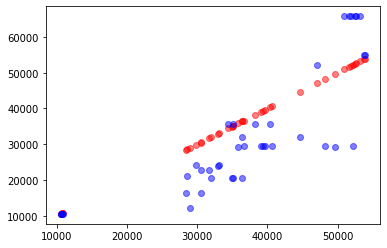

In [812]:
plt.scatter(y_test, y_test, c='red', alpha=0.5)
plt.scatter(y_test, y_pred, c='blue', alpha=0.5)

#### Random Forest Pipeline (Links_SumOfCars com colunas removidas)

In [813]:
forrest_model_reg = RandomForestRegressor(random_state=37)
forrest_model_reg.fit(X_train, y_train)

RandomForestRegressor(random_state=37)

In [814]:
search_paramns = [{
    'forest__criterion': ["squared_error", "absolute_error"],
    'forest__n_estimators': list(range(1, 20, 1)), 
    'forest__max_features': ["sqrt", "log2"]
}]

pipe = Pipeline([
    ('forest', forrest_model_reg)
])

search = GridSearchCV(estimator=pipe,
                     param_grid=search_paramns,
                     cv=5,
                     return_train_score=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [815]:
%%time
search.fit(X_train, y_train)

CPU times: total: 3.16 s
Wall time: 3.18 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('forest',
                                        RandomForestRegressor(random_state=37))]),
             param_grid=[{'forest__criterion': ['squared_error',
                                                'absolute_error'],
                          'forest__max_features': ['sqrt', 'log2'],
                          'forest__n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13, 14, 15, 16,
                                                   17, 18, 19]}],
             return_train_score=True)

In [816]:
search.best_params_

{'forest__criterion': 'absolute_error',
 'forest__max_features': 'sqrt',
 'forest__n_estimators': 6}

In [817]:
search.best_estimator_

Pipeline(steps=[('forest',
                 RandomForestRegressor(criterion='absolute_error',
                                       max_features='sqrt', n_estimators=6,
                                       random_state=37))])

In [818]:
y_pred = search.predict(X_test)

r2_score = forrest_model_reg.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)
print(f'r2: {r2_score}    MSE: {mse}')

r2: 0.5509792181351337    MSE: 55839197.26322753


In [819]:
print_results(y_pred, y_test)

    Mean Absolute Error: 6045.87 degrees.
    Accuracy: 83.0 %.


(83.0, 6045.87)

In [820]:
forrest_model_reg = RandomForestRegressor(n_estimators = 13,criterion='absolute_error',max_features= 'sqrt', random_state=37)
forrest_model_reg.fit(X_train, y_train)

forrest_predictions = forrest_model_reg.predict(X_test)
print_results(forrest_predictions, y_test)

    Mean Absolute Error: 4498.13 degrees.
    Accuracy: 87.12 %.


(87.12, 4498.13)

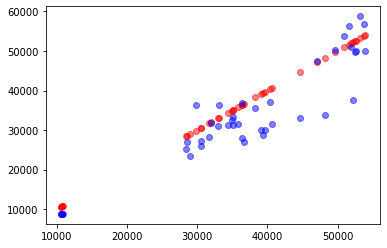

In [821]:
plt.scatter(y_test, y_test, c='red', alpha=0.5)
plt.scatter(y_test, forrest_predictions, c='blue', alpha=0.5)

In [822]:
rf_SumOfCars_LessColumn = save_accuracy(forrest_predictions, y_test)

### Y = Path_LoadedSpeed (colunas removidas)

In [823]:
df_SparseColumn_LoadedSpeed = df_SparseColumns.copy()

In [824]:
y = np.array(df_SparseColumn_LoadedSpeed ['Path_LoadedSpeed'])
X = df_SparseColumn_LoadedSpeed .drop(['Links_SumOfCars', 'Path_LoadedSpeed', 'Path_LoadedTime'], axis = 1)
x_names = list(X.columns)
X = np.array(X)

In [825]:
tscv = TimeSeriesSplit(n_splits=2)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

#### Decision Tree Regressor Pipeline (Path_LoadedSpeed colunas removidas)

In [826]:
DT_regressor = DecisionTreeRegressor(random_state=42)
DT_regressor.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [827]:
search_paramns = [
    dict(dec_tree__criterion=["squared_error", "friedman_mse", "absolute_error", "poisson"],
         dec_tree__max_depth=list(range(10,200,50)),
            dec_tree__max_features=["auto","sqrt", "log2"])
]

pipe = Pipeline([
    ('dec_tree', DT_regressor)
])

search = GridSearchCV(estimator=pipe,
                     param_grid=search_paramns,
                     cv=tscv,
                     return_train_score=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [828]:
%%time
search.fit(X_train, y_train)

CPU times: total: 93.8 ms
Wall time: 112 ms


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=None),
             estimator=Pipeline(steps=[('dec_tree',
                                        DecisionTreeRegressor(random_state=42))]),
             param_grid=[{'dec_tree__criterion': ['squared_error',
                                                  'friedman_mse',
                                                  'absolute_error', 'poisson'],
                          'dec_tree__max_depth': [10, 60, 110, 160],
                          'dec_tree__max_features': ['auto', 'sqrt', 'log2']}],
             return_train_score=True)

In [829]:
search.best_params_

{'dec_tree__criterion': 'poisson',
 'dec_tree__max_depth': 10,
 'dec_tree__max_features': 'sqrt'}

In [830]:
search.best_estimator_

Pipeline(steps=[('dec_tree',
                 DecisionTreeRegressor(criterion='poisson', max_depth=10,
                                       max_features='sqrt', random_state=42))])

In [831]:
y_pred = search.predict(X_test)

r2_score = DT_regressor.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)
print(f'r2: {r2_score}    MSE: {mse}')

r2: -1.1613138686131386    MSE: 24.141666666666666


In [832]:
print_results(y_pred, y_test)

    Mean Absolute Error: 3.59 degrees.
    Accuracy: 85.95 %.


(85.95, 3.59)

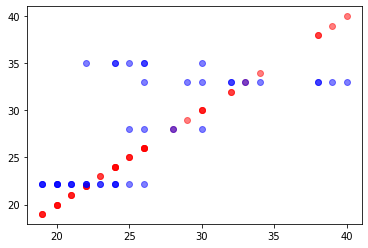

In [833]:
plt.scatter(y_test, y_test, c='red', alpha=0.5)
plt.scatter(y_test, y_pred, c='blue', alpha=0.5)

#### Random Forest Pipeline (Path_LoadedSpeed colunas removidas)

In [834]:
forrest_model_reg = RandomForestRegressor(random_state=37)
forrest_model_reg.fit(X_train, y_train)

RandomForestRegressor(random_state=37)

In [835]:
search_paramns = [{
    'forest__criterion': ["squared_error", "absolute_error"],
    'forest__n_estimators': list(range(10,200, 20)), 
    'forest__max_features': ["sqrt", "log2"]
}]

pipe = Pipeline([
    ('forest', forrest_model_reg)
])

search = GridSearchCV(estimator=pipe,
                     param_grid=search_paramns,
                     cv=5,
                     return_train_score=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [836]:
%%time
search.fit(X_train, y_train)

CPU times: total: 14.5 s
Wall time: 14.6 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('forest',
                                        RandomForestRegressor(random_state=37))]),
             param_grid=[{'forest__criterion': ['squared_error',
                                                'absolute_error'],
                          'forest__max_features': ['sqrt', 'log2'],
                          'forest__n_estimators': [10, 30, 50, 70, 90, 110, 130,
                                                   150, 170, 190]}],
             return_train_score=True)

In [837]:
search.best_params_

{'forest__criterion': 'squared_error',
 'forest__max_features': 'sqrt',
 'forest__n_estimators': 30}

In [838]:
search.best_estimator_

Pipeline(steps=[('forest',
                 RandomForestRegressor(max_features='sqrt', n_estimators=30,
                                       random_state=37))])

In [839]:
y_pred = search.predict(X_test)

r2_score = forrest_model_reg.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)
print(f'r2: {r2_score}    MSE: {mse}')

r2: 0.4423247445255474    MSE: 17.01373015873016


In [840]:
print_results(y_pred, y_test)

    Mean Absolute Error: 3.0 degrees.
    Accuracy: 88.92 %.


(88.92, 3.0)

In [841]:
forrest_model_reg = RandomForestRegressor(n_estimators = 30,criterion='absolute_error',max_features= 'sqrt', random_state=37)
forrest_model_reg.fit(X_train, y_train)

forrest_predictions = forrest_model_reg.predict(X_test)
print_results(forrest_predictions, y_test)

    Mean Absolute Error: 3.52 degrees.
    Accuracy: 87.08 %.


(87.08, 3.52)

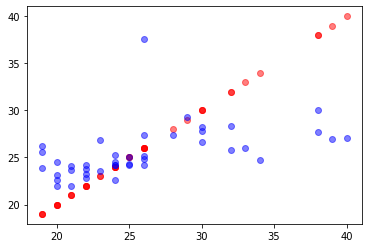

In [842]:
plt.scatter(y_test, y_test, c='red', alpha=0.5)
plt.scatter(y_test, forrest_predictions, c='blue', alpha=0.5)

In [843]:
rf_LoadedSpeed_LessColumn = save_accuracy(forrest_predictions, y_test)

### Y = Path_LoadedTime (colunas removidas)

In [844]:
df_SparseColumn_LoadedTime = df_SparseColumns.copy()

In [845]:
y = np.array(df_SparseColumn_LoadedTime ['Path_LoadedSpeed'])
X = df_SparseColumn_LoadedTime .drop(['Links_SumOfCars', 'Path_LoadedSpeed', 'Path_LoadedTime'], axis = 1)
x_names = list(X.columns)
X = np.array(X)

In [846]:
tscv = TimeSeriesSplit(n_splits=2)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

#### Decision Tree Regressor Pipeline (Path_LoadedSpeed removidas)

In [847]:
DT_regressor = DecisionTreeRegressor(random_state=42)
DT_regressor.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [848]:
search_paramns = [
    dict(dec_tree__criterion=["squared_error", "friedman_mse", "absolute_error", "poisson"],
         dec_tree__max_depth=list(range(10,200,50)),
            dec_tree__max_features=["auto","sqrt", "log2"])
]

pipe = Pipeline([
    ('dec_tree', DT_regressor)
])

search = GridSearchCV(estimator=pipe,
                     param_grid=search_paramns,
                     cv=tscv,
                     return_train_score=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [849]:
%%time
search.fit(X_train, y_train)

CPU times: total: 109 ms
Wall time: 112 ms


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=None),
             estimator=Pipeline(steps=[('dec_tree',
                                        DecisionTreeRegressor(random_state=42))]),
             param_grid=[{'dec_tree__criterion': ['squared_error',
                                                  'friedman_mse',
                                                  'absolute_error', 'poisson'],
                          'dec_tree__max_depth': [10, 60, 110, 160],
                          'dec_tree__max_features': ['auto', 'sqrt', 'log2']}],
             return_train_score=True)

In [850]:
search.best_params_

{'dec_tree__criterion': 'poisson',
 'dec_tree__max_depth': 10,
 'dec_tree__max_features': 'sqrt'}

In [851]:
search.best_estimator_

Pipeline(steps=[('dec_tree',
                 DecisionTreeRegressor(criterion='poisson', max_depth=10,
                                       max_features='sqrt', random_state=42))])

In [852]:
y_pred = search.predict(X_test)

r2_score = DT_regressor.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)
print(f'r2: {r2_score}    MSE: {mse}')

r2: -1.1613138686131386    MSE: 24.141666666666666


In [853]:
print_results(y_pred, y_test)

    Mean Absolute Error: 3.59 degrees.
    Accuracy: 85.95 %.


(85.95, 3.59)

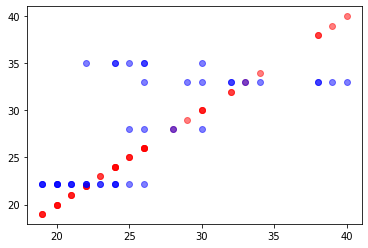

In [854]:
plt.scatter(y_test, y_test, c='red', alpha=0.5)
plt.scatter(y_test, y_pred, c='blue', alpha=0.5)

#### Random Forest Pipeline (Path_LoadedSpeed colunas removidas)

In [855]:
forrest_model_reg = RandomForestRegressor(random_state=37)
forrest_model_reg.fit(X_train, y_train)

RandomForestRegressor(random_state=37)

In [856]:
search_paramns = [{
    'forest__criterion': ["squared_error", "absolute_error"],
    'forest__n_estimators': list(range(10,30, 1)), 
    'forest__max_features': ["sqrt", "log2"]
}]

pipe = Pipeline([
    ('forest', forrest_model_reg)
])

search = GridSearchCV(estimator=pipe,
                     param_grid=search_paramns,
                     cv=5,
                     return_train_score=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [857]:
%%time
search.fit(X_train, y_train)

CPU times: total: 6.14 s
Wall time: 6.21 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('forest',
                                        RandomForestRegressor(random_state=37))]),
             param_grid=[{'forest__criterion': ['squared_error',
                                                'absolute_error'],
                          'forest__max_features': ['sqrt', 'log2'],
                          'forest__n_estimators': [10, 11, 12, 13, 14, 15, 16,
                                                   17, 18, 19, 20, 21, 22, 23,
                                                   24, 25, 26, 27, 28, 29]}],
             return_train_score=True)

In [858]:
search.best_params_

{'forest__criterion': 'squared_error',
 'forest__max_features': 'sqrt',
 'forest__n_estimators': 15}

In [859]:
search.best_estimator_

Pipeline(steps=[('forest',
                 RandomForestRegressor(max_features='sqrt', n_estimators=15,
                                       random_state=37))])

In [860]:
y_pred = search.predict(X_test)

r2_score = forrest_model_reg.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)
print(f'r2: {r2_score}    MSE: {mse}')

r2: 0.4423247445255474    MSE: 18.535449735449735


In [861]:
print_results(y_pred, y_test)

    Mean Absolute Error: 3.26 degrees.
    Accuracy: 87.84 %.


(87.84, 3.26)

In [862]:
forrest_model_reg = RandomForestRegressor(n_estimators = 23,criterion='absolute_error',max_features= 'sqrt', random_state=37)
forrest_model_reg.fit(X_train, y_train)

forrest_predictions = forrest_model_reg.predict(X_test)
print_results(forrest_predictions, y_test)

    Mean Absolute Error: 3.47 degrees.
    Accuracy: 87.18 %.


(87.18, 3.47)

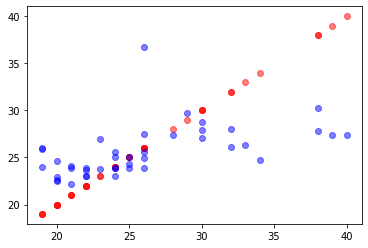

In [863]:
plt.scatter(y_test, y_test, c='red', alpha=0.5)
plt.scatter(y_test, forrest_predictions, c='blue', alpha=0.5)

In [864]:
rf_LoadedTime_LessColumn = save_accuracy(forrest_predictions, y_test)

# Resultados

In [865]:
print("Acurácia da Random Forest na predição do número de veículos num determinado caminho:")
print("Dados simulados completos (30 colunas de dados): ", rf_SumOfCars, "%")
print("30% dos dados esparsados aleatoriamente", rf_SumOfCars_Sparse, "%")
print("Colunas removidas (13 colunas de dados): ", rf_SumOfCars_LessColumn, "%")
print("-------------------------------------------------------------------------------------------------------------")
print("Acurácia da Random Forest na predição da velocidade de locomoção média dos veículos num determinado caminho:")
print("Dados simulados completos (30 colunas de dados): ", rf_LoadedSpeed, "%")
print("30% dos dados esparsados aleatoriamente", rf_LoadedSpeed_Sparse, "%")
print("Colunas removidas (13 colunas de dados): ", rf_LoadedSpeed_LessColumn, "%")
print("-------------------------------------------------------------------------------------------------------------")
print("Acurácia da Random Forest do tempo de locomoção média dos veículos num determinado caminho:")
print("Dados simulados completos (30 colunas de dados): ", rf_LoadedTime, "%")
print("30% dos dados esparsados aleatoriamente", rf_LoadedTime_Sparse, "%")
print("Colunas removidas (13 colunas de dados): ", rf_LoadedTime_LessColumn, "%")

Acurácia da Random Forest na predição do número de veículos num determinado caminho:
Dados simulados completos (30 colunas de dados):  93.6 %
30% dos dados esparsados aleatoriamente 76.65 %
Colunas removidas (13 colunas de dados):  87.12 %
-------------------------------------------------------------------------------------------------------------
Acurácia da Random Forest na predição da velocidade de locomoção média dos veículos num determinado caminho:
Dados simulados completos (30 colunas de dados):  89.89 %
30% dos dados esparsados aleatoriamente 88.47 %
Colunas removidas (13 colunas de dados):  87.08 %
-------------------------------------------------------------------------------------------------------------
Acurácia da Random Forest do tempo de locomoção média dos veículos num determinado caminho:
Dados simulados completos (30 colunas de dados):  87.86 %
30% dos dados esparsados aleatoriamente 87.83 %
Colunas removidas (13 colunas de dados):  87.18 %
